In [1]:
#Load modules 
import pickle, time, math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import pairwise_distances

# Set defaults for figures
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16
plt.rcParams["savefig.format"] = 'pdf'

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='bright')
plt.style.use('../clint.mpl')


# Load data dict
with open('data_dict_train.pickle', 'rb') as handle:
    data_dict = pickle.load(handle)
data_dict 

{'dwts': array([[ -29.74268  ,  -45.122246 ,    3.1377835, ...,   64.12575  ,
           40.968002 ,  -88.25577  ],
        [ -36.34418  ,    5.9054475,    8.5570965, ...,   34.89682  ,
           21.461796 ,    5.37512  ],
        [ -68.672226 ,  -49.933884 ,  -12.634004 , ...,   20.953556 ,
           31.913715 ,   67.26906  ],
        ...,
        [  28.798027 ,   81.83103  ,   25.262493 , ...,  -40.67521  ,
          -31.30605  ,  -47.5695   ],
        [ -58.413643 ,  -45.685726 ,  -35.43268  , ...,   49.950462 ,
           49.066578 ,   -9.800057 ],
        [  23.395285 ,  -17.440125 ,   26.400492 , ...,  -49.613483 ,
          -61.28074  , -114.490524 ]], dtype=float32),
 'energies': array([0, 0, 0, ..., 0, 0, 0], dtype=uint16),
 'cards': array([1, 1, 1, ..., 9, 9, 9], dtype=uint8),
 'chs_orca': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)}

In [2]:
#Load waveforms

dwts = data_dict['dwts']

#Normalize wfs

dwts_norm = np.zeros(dwts.shape)
for i in range(dwts.shape[0]):
    maximum, minimum = np.amax(dwts[i,:]), np.amin(dwts[i,:])
    if abs(maximum) >= abs(minimum):
        dwts_norm[i,:] = dwts[i,:]/maximum
    elif abs(maximum) < abs(minimum):
        dwts_norm[i,:] = dwts[i,:]/(-1*minimum)
print(dwts_norm.shape)  

(9982, 256)


In [3]:
#Precompute similarity matrix 

start_time = time.time()
similarities = -pairwise_distances(dwts_norm, metric='l1')
print("--- %s seconds ---" % (time.time() - start_time))

print('Median = ', np.median(similarities))
print('Min = ', np.amin(similarities))

--- 14.46230673789978 seconds ---
Median =  -103.00900961458683
Min =  -391.90574131850735


In [4]:
#Find clusters with Affinity Propagation

start_time = time.time()
ap = AffinityPropagation(max_iter=500,
                         convergence_iter=25, 
                         verbose=True,
                         random_state=0,
                         preference=-110,
                         damping=0.99,
                         affinity='precomputed').fit(X=similarities)
print("--- %s seconds ---" % (time.time() - start_time))

nwave = len(ap.cluster_centers_indices_)
print(nwave, "clusters found")

Converged after 257 iterations.
--- 444.36843705177307 seconds ---
45


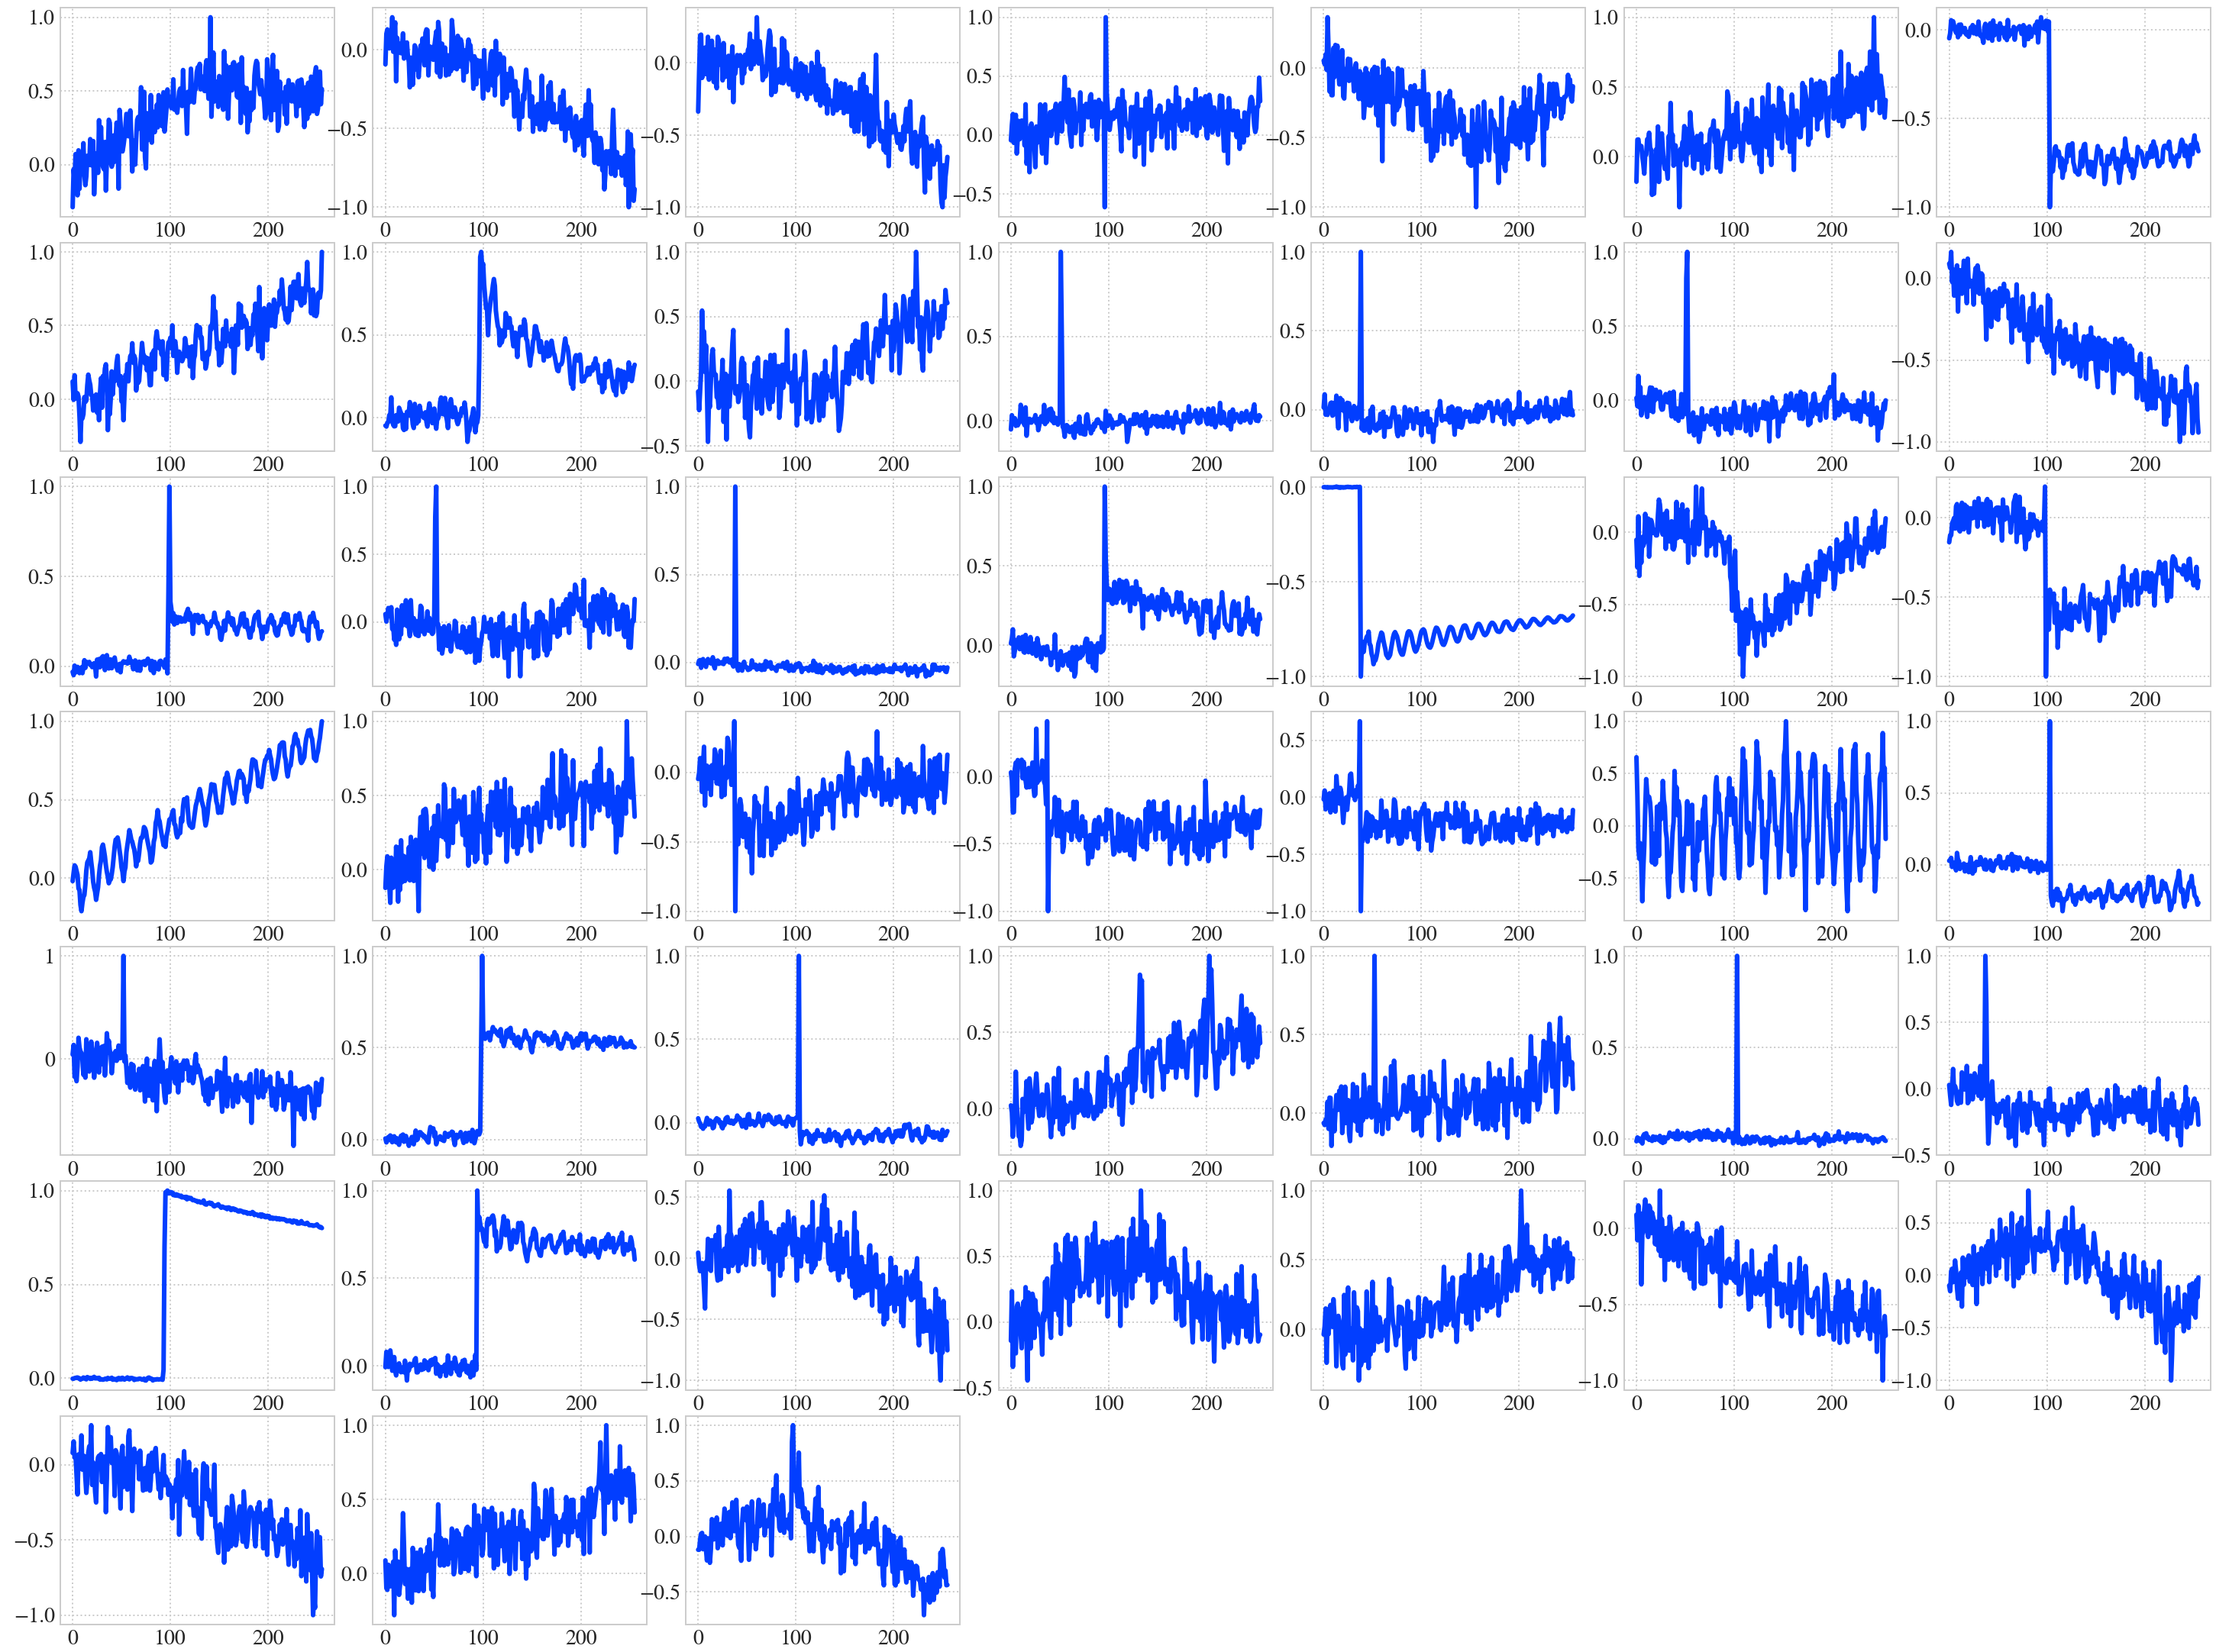

In [6]:
#Plot all exemplars (cluster centers)

plt.figure(figsize=(40,30))
for j in range(nwave):
    plt.subplot(math.ceil((nwave)**0.5),math.ceil((nwave)**0.5),j+1)
    idx = ap.cluster_centers_indices_[j] 
    wf = dwts_norm[idx]
    plt.plot(wf, linestyle="-")
# plt.savefig('exemplars_phys')

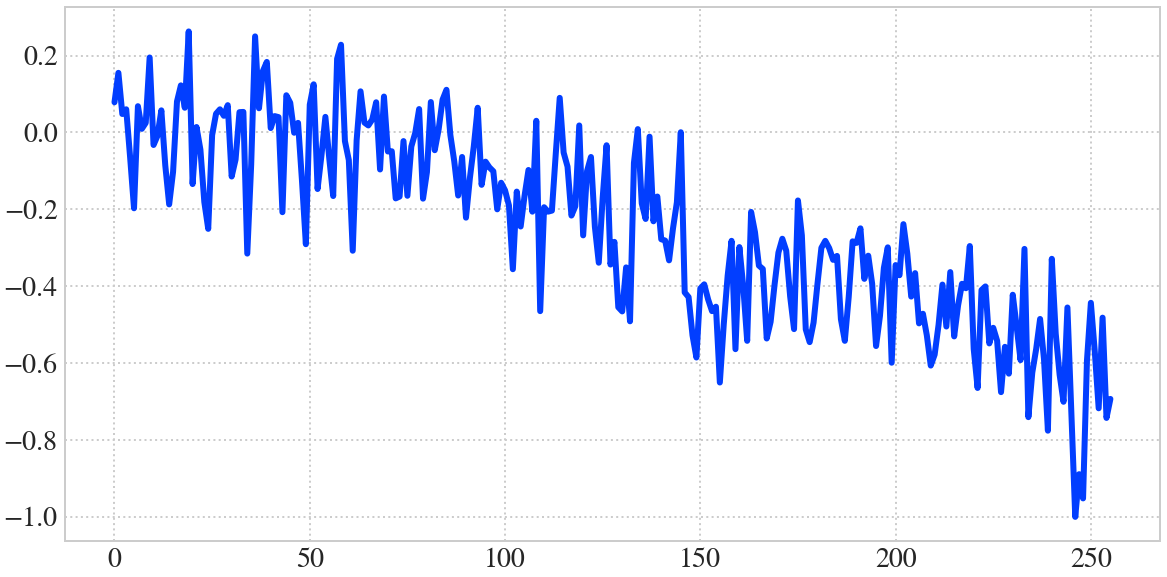

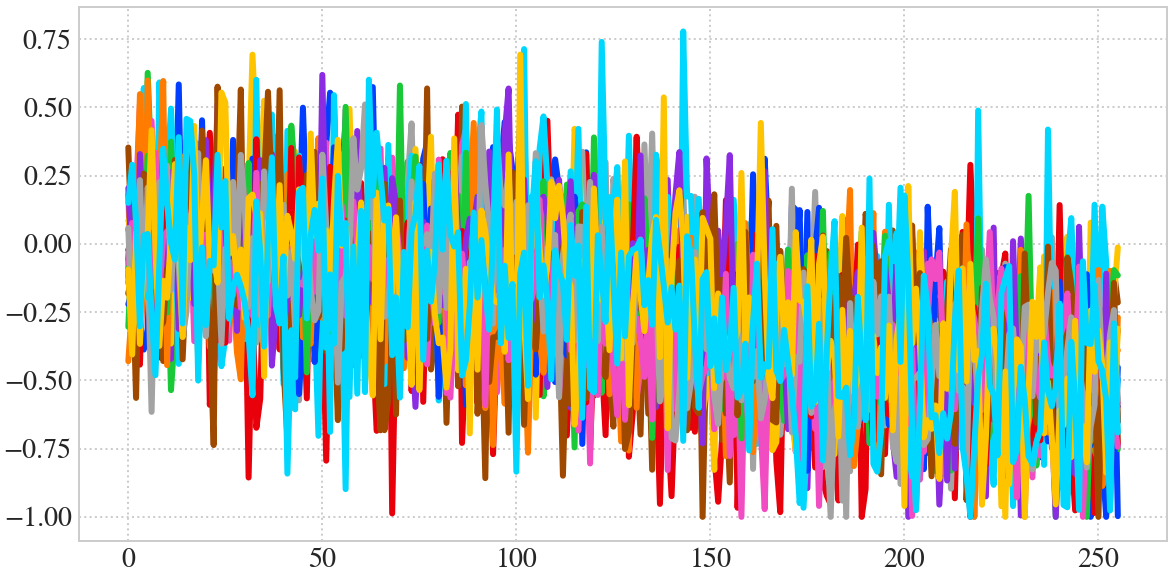

In [7]:
#Look at waveforms inside a given cluster

ex = 42
idx = ap.cluster_centers_indices_[ex] 
wf = dwts_norm[idx,:]
fig, axs = plt.subplots(1, 1, figsize=(16, 8))
axs.plot(wf, linestyle="-", c='b')

samples = np.where((ap.labels_ == ex))[0][0:20]
fig1, ax1 = plt.subplots(1, 1, figsize=(16, 8))
for i in samples:
    ax1.plot(dwts_norm[i,:]) 

In [8]:
#Initialize label arrays 

labels = ap.labels_
energies = data_dict['energies']
n_events = dwts_norm.shape[0]
dc_labels = np.zeros(n_events)

In [9]:
#Loop through all events and set tag corresponding to data cleaning category

for i in range(n_events):
    
    if labels[i] in [8,35,36] and energies[i] > 0: #normal
        dc_labels[i] = 0
    elif labels[i] in [6,18,19,20] and energies[i] > 0: #negative going
        dc_labels[i] = 1
    elif labels[i] in [5,7,21,43] and energies[i] > 0: #upwards sloping
        dc_labels[i] = 2
    elif labels[i] in [1,2,13,40,42]: #downwards sloping 
        dc_labels[i] = 3
    elif  labels[i] in [3,10,11,12,14,15,16,17,23,24,25,27,28,29,30,32,33,34] and energies[i] > 0: #spike
        dc_labels[i] = 4
    # if labels[i]==6 or labels[i]==16 or labels[i]==20: #cross-talk
    #     dc_labels[i] = 5
    # if labels[i] in [12,15,22]: #slow rise
        # dc_labels[i] = 6
    # if labels[i]==44 or labels[i]==48: #early trigger
    #     dc_labels[i] = 7
    # if labels[i]==43 or labels[i]==47: #late trigger
    #     dc_labels[i] = 8
    # if labels[i] in [24,25]: #saturation
        # dc_labels[i] = 9
    # if labels[i] in [21]: #soft pileup
        # dc_labels[i] = 10
    # if labels[i] in [0,1,5,6,8,13,14,18,19,23,26,27,32]: #hard pileup
        # dc_labels[i] = 11
    elif labels[i] in [0,4,9,22,26,31,37,38,39,41,44] or energies[i] == 0 and dc_labels[i] != 3: #noise trigger
        dc_labels[i] = 12


In [13]:
# Define dictionary with labels and dwts

tags_dict = {
    "exLabel": labels,
    "dcLabel": dc_labels,
    "energies": data_dict['energies'],
    "dwts_norm": dwts_norm
}
tags_dict

{'exLabel': array([27, 10, 14, ..., 23, 30, 28]),
 'dcLabel': array([12., 12., 12., ..., 12., 12., 12.]),
 'energies': array([0, 0, 0, ..., 0, 0, 0], dtype=uint16),
 'dwts_norm': array([[-0.30800915, -0.46727684,  0.03249425, ...,  0.66407323,
          0.42425632, -0.91395885],
        [-0.33626375,  0.0546384 ,  0.07917199, ...,  0.32287246,
          0.1985689 ,  0.0497317 ],
        [-0.75499552, -0.54898262, -0.13890064, ...,  0.23036738,
          0.35086545,  0.73956883],
        ...,
        [ 0.24130908,  0.68569177,  0.21168356, ..., -0.34083229,
         -0.26232469, -0.39860204],
        [-0.53866524, -0.42129394, -0.32674477, ...,  0.46062148,
          0.45247069, -0.09037188],
        [ 0.18237799, -0.13595453,  0.20580509, ..., -0.38676202,
         -0.47771415, -0.89251113]])}

In [23]:
# Save normalized waveforms and new labels

with open('tags_dict.pickle', 'wb') as handle:
    pickle.dump(tags_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)